<h1>Data cube smoothing quick recipes</h1>

This notebook contains a few script snippets that demonstrate the "best" way to smooth cube data.



In [11]:
# All imports used in this script

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.io import fits
from __future__ import print_function

from scipy.ndimage import gaussian_filter

from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel, AiryDisk2DKernel

import time # for timing measurements

%matplotlib inline

<h3>Read data cube from FITS file</h3>

In [12]:
datacube = fits.getdata('./data/Eagle.fits')
datacube.shape

(6000, 26, 143)

<h3>Display one spatial plane (image) from cube</h3>

Then compare this with its smoothed versions below.

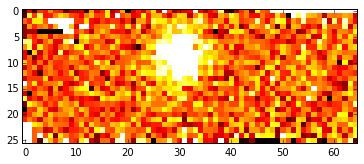

In [13]:
fig, ax = plt.subplots(figsize=(6, 9))
image = datacube[3358, :, 45:110]       # slice with spatial plane at spectral pixel #3358
ax.imshow(image, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')

<h3>Display one spectrum from cube</h3>

Then compare this with its smoothed versions below.

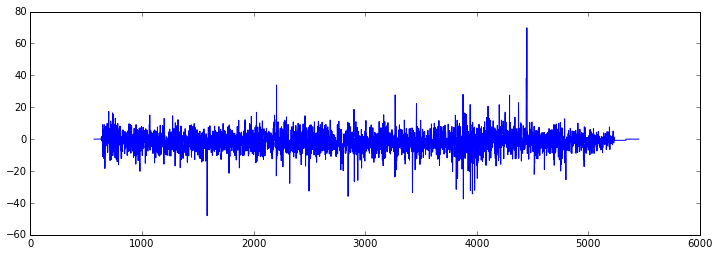

In [14]:
plt.gcf().set_size_inches(12.,4.)
spectrum = datacube[:, 8, 30]        # slice with spectrum at pixel y=8, x=30
plt.plot(spectrum)

<h2> Recipe 1: single-pass 3-D operator (scipy) </h2>

This can be used if:
 - a Gaussian kernel is appropriate for both spatial and spectral dimensions,
 - presence of NaN-valued data is not an issue,
 - you need a fast response.

In [15]:
start_time = time.time()

# spatial kernel FWHM = 0.75 pixel; spectral kernel FWHM = 1.5 pixels
fcube = gaussian_filter(datacube, (1.5, 0.75, 0.75)) 

end_time = time.time()
print(str(end_time - start_time) + " seconds.")

1.38467812538 seconds.


<h3>Display same image plane and spectrum as above</h3>

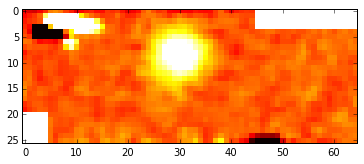

In [16]:
fig, ax = plt.subplots(figsize=(6, 9))
ax.imshow(fcube[3358, :, 45:110], cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')

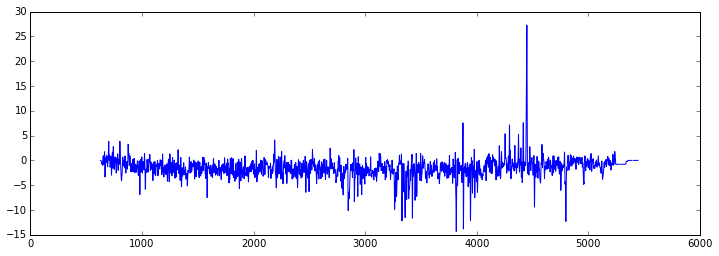

In [17]:
plt.gcf().set_size_inches(12.,4.)
spectrum = fcube[:, 8, 30]
plt.plot(spectrum)

<h2>Recipe 2: multiple 2D/1D passes (astropy)</h2>

This should be used if:
 - the problem calls for different kernels for spatial and spectral dimensions,
 - NaN-valued data should be properly handled
 - computation time is not a major issue

In [18]:
inter = np.zeros(shape=datacube.shape)   # result of first pass (2-D smoothing) goes here
result = np.zeros(shape=datacube.shape)  # final result goes here

k1 = Gaussian1DKernel(1.5)     # spectral (1-D) kernel
k2 = AiryDisk2DKernel(2.)      # spatial (2-D) kernel

start_time = time.time()

# spatial smoothing
for i in range(datacube.shape[0]):
    inter[i,:,:] = convolve(datacube[i,:,:], k2)
# spectral smoothing
for i in range(datacube.shape[1]):
    for j in range(datacube.shape[2]):
        result[:,i,j] = convolve(inter[:,i,j], k1)

end_time = time.time()
print(str(end_time - start_time) + " seconds.")

33.0059797764 seconds.


<h3>Display same image plane and spectrum as above</h3>

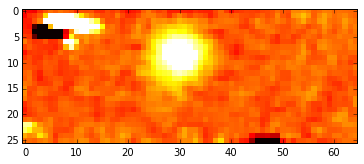

In [19]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(result[3358, :, 45:110], cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')

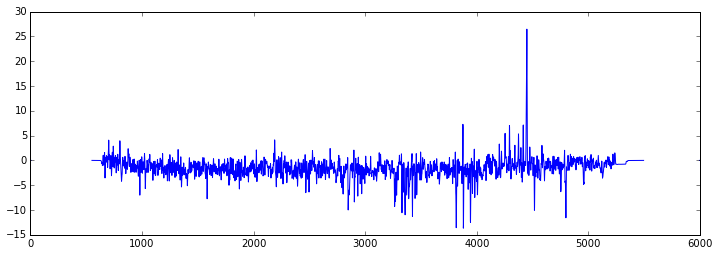

In [20]:
plt.gcf().set_size_inches(12.,4.)
spectrum = result[:, 8, 30]
plt.plot(spectrum)